【参考文献】
【核】
https://qiita.com/m__k/items/646044788c5f94eadc8d

In [12]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# 事前にGoogle Driveをマウントして以下の場所にdate.txtを格納しておく
file_path = "date.txt"

input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
  date_list = f.readlines()
  for date in date_list:
    date = date[:-1]
    input_date.append(date.split("_")[0])
    output_date.append("_" + date.split("_")[1])

# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10



50000


In [14]:
# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
  for c in input_chars:
    if not c in char2id:
      char2id[c] = len(char2id)
  for c in output_chars:
    if not c in char2id:
      char2id[c] = len(char2id)

In [15]:
input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
  input_data.append([char2id[c] for c in input_chars])
  output_data.append([char2id[c] for c in output_chars])

In [16]:
# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

In [17]:
# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# 諸々のパラメータなど
embedding_dim = 200
hidden_dim = 128
BATCH_NUM = 100
vocab_size = len(char2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # hsが各系列のGRUの隠れ層のベクトル
        # Attentionされる要素
        hs, h = self.gru(embedding)
        return hs, h

In [19]:
# Attention Decoderクラス
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim*2としているのは、各系列のGRUの隠れ層とAttention層で計算したコンテキストベクトルをtorch.catでつなぎ合わせることで長さが２倍になるため
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # 列方向を確率変換したいのでdim=1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)

       # Attention層
       # hs.size() = ([100, 29, 128])
       # output.size() = ([100, 10, 128])

       # bmmを使ってEncoder側の出力(hs)とDecoder側の出力(output)をbatchごとまとめて行列計算するために、Decoder側のoutputをbatchを固定して転置行列を取る
        t_output = torch.transpose(output, 1, 2) # t_output.size() = ([100, 128, 10])

        # bmmでバッチも考慮してまとめて行列計算
        s = torch.bmm(hs, t_output) # s.size() = ([100, 29, 10])

        # 列方向(dim=1)でsoftmaxをとって確率表現に変換
        # この値を後のAttentionの可視化などにも使うため、returnで返しておく
        attention_weight = self.softmax(s) # attention_weight.size() = ([100, 29, 10])

        # コンテキストベクトルをまとめるために入れ物を用意
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device) # c.size() = ([100, 1, 128])

        # 各DecoderのGRU層に対するコンテキストベクトルをまとめて計算する方法がわからなかったので、
        # 各層（Decoder側のGRU層は生成文字列が10文字なので10個ある）におけるattention weightを取り出してforループ内でコンテキストベクトルを１つずつ作成する
        # バッチ方向はまとめて計算できたのでバッチはそのまま
        for i in range(attention_weight.size()[2]): # 10回ループ

          # attention_weight[:,:,i].size() = ([100, 29])
          # i番目のGRU層に対するattention weightを取り出すが、テンソルのサイズをhsと揃えるためにunsqueezeする
          unsq_weight = attention_weight[:,:,i].unsqueeze(2) # unsq_weight.size() = ([100, 29, 1])

          # hsの各ベクトルをattention weightで重み付けする
          weighted_hs = hs * unsq_weight # weighted_hs.size() = ([100, 29, 128])

          # attention weightで重み付けされた各hsのベクトルをすべて足し合わせてコンテキストベクトルを作成
          weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1) # weight_sum.size() = ([100, 1, 128])

          c = torch.cat([c, weight_sum], dim=1) # c.size() = ([100, i, 128])
          
        # 箱として用意したzero要素が残っているのでスライスして削除
        c = c[:,1:,:]

        output = torch.cat([output, c], dim=2) # output.size() = ([100, 10, 256])
        output = self.hidden2linear(output)
        return output, state, attention_weight

In [21]:

encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
attn_decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=0.001)

In [23]:
BATCH_NUM=100
EPOCH_NUM = 100

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)
    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        attn_decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬
        hs, h = encoder(input_tensor)

        # Attention Decoderのインプット
        source = output_tensor[:, :-1]

        # Attention Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _, attention_weight= attn_decoder(source, hs, h)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        encoder_optimizer.step()
        attn_decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 0.1: break
print("Done")

training ...
Epoch 1: 1637.91
Epoch 2: 74.50
Epoch 3: 10.17


KeyboardInterrupt: 

NameError: name 'all_losses' is not defined

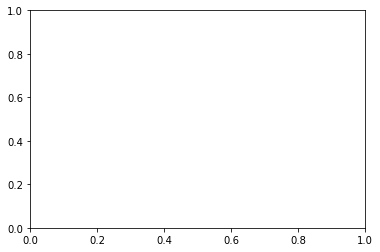

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
plt.style.use('ggplot')
ax.plot(all_losses, label='train loss')
#ax.plot(val_losses, label='val loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("/public/tsukaue/study_party/Attention/loss of attentionSeq2seq.png")